In [1]:
import pandas as pd
import os, random
import numpy as np
import sklearn
from sklearn import metrics, ensemble, tree, inspection, model_selection
import catboost as cb
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt 
import matplotlib as mpl
import seaborn as sns
import shap
from pdpbox import pdp, info_plots
from PyALE import ale
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

In [2]:
redfin_df = pd.read_csv('redfin_0325.csv')

In [3]:
redfin_df.columns

Index(['field_1', 'index', 'SALE TYPE', 'PROP_TYPE', 'ADDRESS', 'CITY',
       'STATE', 'ZIP', 'PRICE', 'BEDS', 'BATHS', 'LOCATION', 'LOT', 'YR_BUILT',
       'DAYS ON MA', 'HOA/MONTH', 'STATUS', 'URL', 'SOURCE', 'MLS#',
       'FAVORITE', 'INTERESTED', 'LATITUDE', 'LONGITUDE', 'PARK_DIST',
       'HOSPITAL_D', 'RAIL_DIST', 'ESCHOOL', 'HSCHOOL', 'BUS_COUNTS',
       'FnB_COUNTS', 'COMMUNITY', 'ndvi', 'treesN10', 'SIDE'],
      dtype='object')

In [4]:
redfin_df.PROP_TYPE.value_counts()

Condo/Co-op                  1176
Single Family Residential     907
Multi-Family                  372
Townhouse                     111
Name: PROP_TYPE, dtype: int64

In [5]:
condo_df = redfin_df[redfin_df.PROP_TYPE == 'Condo/Co-op']
single_fam_df = redfin_df[redfin_df.PROP_TYPE == 'Single Family Residential']

In [6]:
import os
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import ensemble
import catboost as cb
import xgboost as xgb
import joblib 

# Random Seed
rand = 42
os.environ['PYTHONHASHSEED'] = str(rand)
np.random.seed(rand)
random.seed(rand)

save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# Remove Features
base_to_drop = [
    'PROP_TYPE', 'ESCHOOL', 'HSCHOOL', 'field_1', 'CITY', 'STATE', 'SALE TYPE',
    'ADDRESS', 'LOCATION', 'STATUS', 'URL', 'SOURCE', 'MLS#', 'FAVORITE',
    'INTERESTED', 'SIDE', 'COMMUNITY', 'treesN10'
]

# Property Types
dfs = [redfin_df, condo_df, single_fam_df]
df_names = ['All', 'Condo', 'SingleFam']

# UGS Settings
ugs_settings = {
    'No UGS': ['ndvi', 'PARK_DIST','treesN10'],
    'Only DIST': ['ndvi'],
    'Only NDVI': ['PARK_DIST'],
    'Both DIST+NDVI': []
}

# Loop - Models
results = []

for df_name, df in zip(df_names, dfs):
    for ugs_name, ugs_cols in ugs_settings.items():
        setting_id = f"{df_name}__{ugs_name.replace(' ', '_')}"
        to_drop = base_to_drop + ugs_cols
        target_col = 'PRICE'

        # 拆分数据
        X = df.drop(columns=to_drop + [target_col])
        y = df[target_col]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rand)

        # ---------- CatBoost ----------
        cb_mdl = cb.CatBoostRegressor(depth=7, learning_rate=0.2, random_state=rand, verbose=False)
        cb_mdl.fit(X_train, y_train)
        cb_preds = cb_mdl.predict(X_test)
        cb_rmse = np.sqrt(mean_squared_error(y_test, cb_preds))
        cb_r2 = r2_score(y_test, cb_preds)

        cb_path = os.path.join(save_dir, f"{setting_id}__catboost.cbm")
        cb_mdl.save_model(cb_path)

        # ---------- Random Forest ----------
        rf_mdl = ensemble.RandomForestRegressor(n_jobs=-1, random_state=rand)
        rf_mdl.fit(X_train.to_numpy(), y_train.to_numpy())
        rf_preds = rf_mdl.predict(X_test.to_numpy())
        rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
        rf_r2 = r2_score(y_test, rf_preds)

        rf_path = os.path.join(save_dir, f"{setting_id}__rf.pkl")
        joblib.dump(rf_mdl, rf_path)

        # ---------- XGBoost ----------
        xgb_mdl = xgb.XGBRegressor(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.2,
            random_state=rand,
            n_jobs=-1,
            verbosity=0  
        )
        xgb_mdl.fit(X_train.to_numpy(), y_train.to_numpy())
        xgb_preds = xgb_mdl.predict(X_test.to_numpy())
        xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
        xgb_r2 = r2_score(y_test, xgb_preds)

        xgb_path = os.path.join(save_dir, f"{setting_id}__xgb.json")
        xgb_mdl.save_model(xgb_path)

        joblib.dump({
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test,
            'feature_names': X.columns.tolist()
        }, os.path.join(save_dir, f"{setting_id}__data.pkl"))

        results.append({
            'Data': df_name,
            'UGS Setting': ugs_name,
            'CatBoost RMSE': cb_rmse,
            'CatBoost R2': cb_r2,
            'RF RMSE': rf_rmse,
            'RF R2': rf_r2,
            'XGB RMSE': xgb_rmse,
            'XGB R2': xgb_r2,
        })

# Export
results_df = pd.DataFrame(results)
results_df = results_df[[
    'Data', 'UGS Setting',
    'CatBoost RMSE', 'CatBoost R2',
    'RF RMSE', 'RF R2',
    'XGB RMSE', 'XGB R2'
]]
print(results_df)


         Data     UGS Setting  CatBoost RMSE  CatBoost R2        RF RMSE  \
0         All          No UGS  103593.013004     0.843948  109712.327702   
1         All       Only DIST  106973.280234     0.833597  110320.737489   
2         All       Only NDVI  104381.804366     0.841562  110055.897954   
3         All  Both DIST+NDVI  109886.081645     0.824412  110174.910059   
4       Condo          No UGS  113589.964984     0.828689  113711.762618   
5       Condo       Only DIST  111720.676641     0.834281  113876.273577   
6       Condo       Only NDVI  111872.008704     0.833831  114386.938935   
7       Condo  Both DIST+NDVI  113640.039851     0.828538  114125.831100   
8   SingleFam          No UGS  113019.679646     0.818612  113337.267791   
9   SingleFam       Only DIST  111476.301457     0.823532  113211.802964   
10  SingleFam       Only NDVI  108974.513198     0.831364  112650.474195   
11  SingleFam  Both DIST+NDVI  109413.650236     0.830002  112749.653721   

       RF R

In [7]:
# Group by Property Types
grouped = results_df.groupby('Data')

for name, group in grouped:
    print(f"\n📊 {name}:")
    print(group.set_index('UGS Setting').drop(columns='Data'))



📊 All:
                CatBoost RMSE  CatBoost R2        RF RMSE     RF R2  \
UGS Setting                                                           
No UGS          103593.013004     0.843948  109712.327702  0.824967   
Only DIST       106973.280234     0.833597  110320.737489  0.823020   
Only NDVI       104381.804366     0.841562  110055.897954  0.823869   
Both DIST+NDVI  109886.081645     0.824412  110174.910059  0.823488   

                     XGB RMSE    XGB R2  
UGS Setting                              
No UGS          106038.765556  0.836492  
Only DIST       108614.033264  0.828454  
Only NDVI       107241.078057  0.832763  
Both DIST+NDVI  111441.093412  0.819407  

📊 Condo:
                CatBoost RMSE  CatBoost R2        RF RMSE     RF R2  \
UGS Setting                                                           
No UGS          113589.964984     0.828689  113711.762618  0.828321   
Only DIST       111720.676641     0.834281  113876.273577  0.827824   
Only NDVI       111

In [8]:
results_df.to_excel('model_results.xlsx', index=False)

In [10]:
import joblib
import catboost as cb

# Example: import single family dist and ndvi model
setting_id = "SingleFam__Both_DIST+NDVI"

cb_mdl = cb.CatBoostRegressor()
cb_mdl.load_model(f"saved_models/{setting_id}__catboost.cbm")

rf_mdl = joblib.load(f"saved_models/{setting_id}__rf.pkl")

data_bundle = joblib.load(f"saved_models/{setting_id}__data.pkl")
X_train = data_bundle['X_train']
X_test = data_bundle['X_test']
y_train = data_bundle['y_train']
y_test = data_bundle['y_test']


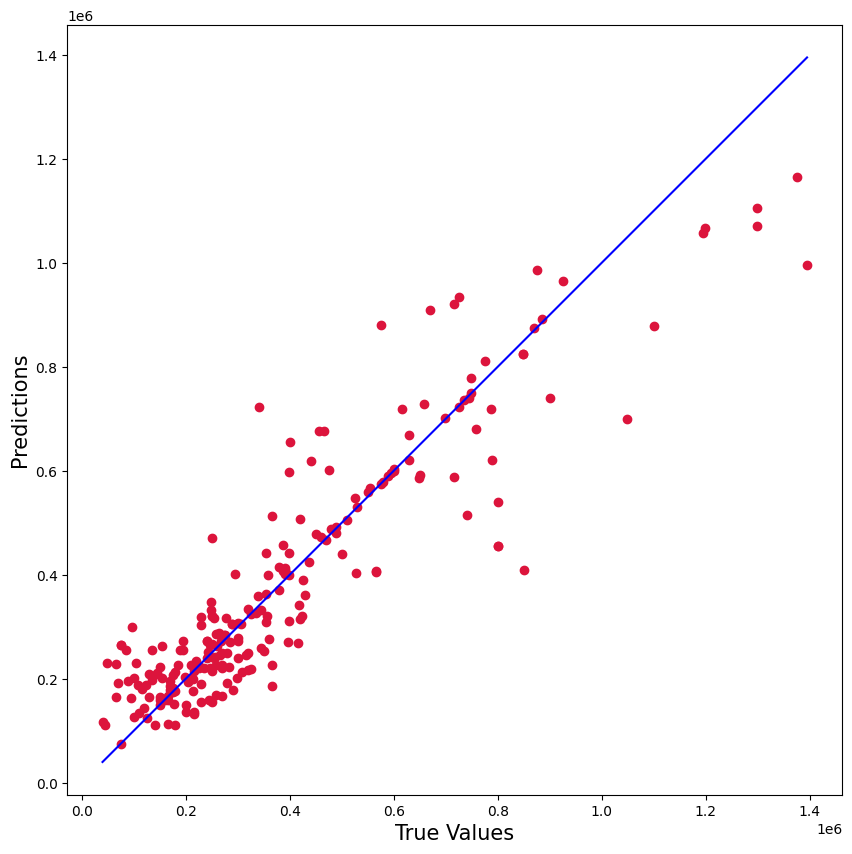

In [11]:
# Cat Boost: Predicted vs. True Value

plt.figure(figsize=(10,10))
true_value = y_test.to_numpy()
predicted_value = cb_mdl.predict(X_test.to_numpy())
plt.scatter(true_value, predicted_value, c='crimson')


p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

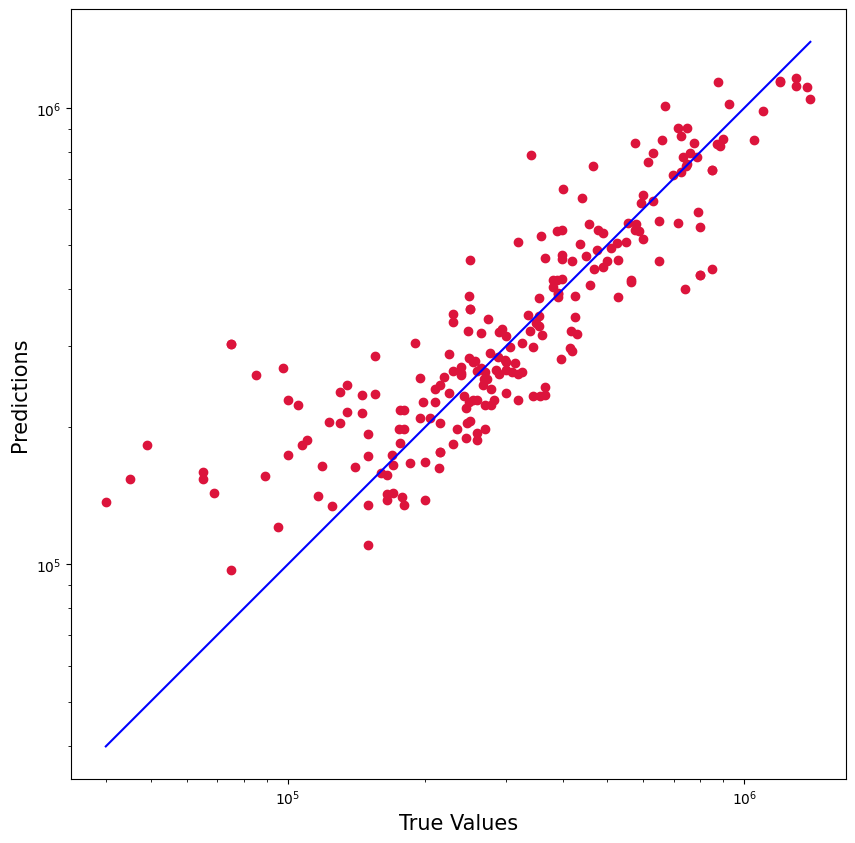

In [12]:
# Random Forest: Predicted vs. True Value

plt.figure(figsize=(10,10))
true_value = y_test.to_numpy()
predicted_value = rf_mdl.predict(X_test.to_numpy())
plt.scatter(true_value, predicted_value, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

## Permutation Feature Importance

In [13]:
# Calculate Permuation Importance

%time
X_samp = X_test.sample(frac=0.3)
y_samp = y_test.loc[X_samp.index]

cb_perm_imp = inspection.permutation_importance(cb_mdl, X_samp, y_samp,\
                                                n_repeats=5, random_state=rand,\
                                                scoring='neg_mean_absolute_error')
rf_perm_imp = inspection.permutation_importance(rf_mdl, X_samp.to_numpy(),\
                                                y_samp.to_numpy(), n_repeats=5,\
                                                random_state=rand, scoring='neg_mean_absolute_error')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 9.3 µs


In [14]:
perm_imp_df = pd.DataFrame({'feature':X_train.columns, 'cb_perm_mean':cb_perm_imp.importances_mean,\
                            'cb_perm_std':cb_perm_imp.importances_std,\
                            'rf_perm_mean':rf_perm_imp.importances_mean,\
                            'rf_perm_std':rf_perm_imp.importances_std})
perm_imp_df = perm_imp_df.sort_values('cb_perm_mean', ascending=False)
perm_imp_df.style.format('{:.4f}', subset=['cb_perm_mean', 'cb_perm_std', 'rf_perm_mean', 'rf_perm_std']).\
                bar(subset=['cb_perm_mean', 'rf_perm_mean'], color='#4EF', width=60)

,feature,cb_perm_mean,cb_perm_std,rf_perm_mean,rf_perm_std
3,BATHS,70090.7349,2144.6482,70219.1464,7100.0960
8,LATITUDE,56617.2688,10283.8175,82652.4783,10416.9887
14,FnB_COUNTS,53024.3100,7637.2511,59101.8009,6163.6639
5,YR_BUILT,16410.0379,3027.1248,10686.2759,2982.3982
12,RAIL_DIST,12277.7279,1744.2880,2531.7616,717.4870
11,HOSPITAL_D,9301.7883,1600.7834,803.9980,341.9196
4,LOT,7559.2235,1507.2468,2144.3423,946.7884
9,LONGITUDE,7553.2748,874.5254,5243.5487,1311.7141
15,ndvi,5551.6339,1743.7541,4917.8632,1176.2653
13,BUS_COUNTS,4168.7079,1735.6465,1080.9398,859.0564


## PDP - SHAP

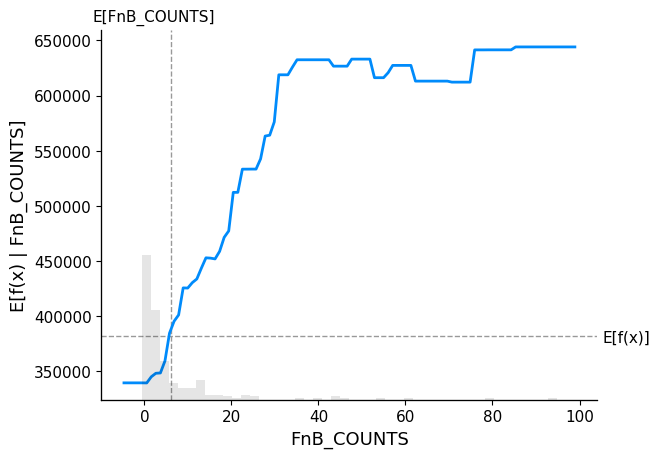

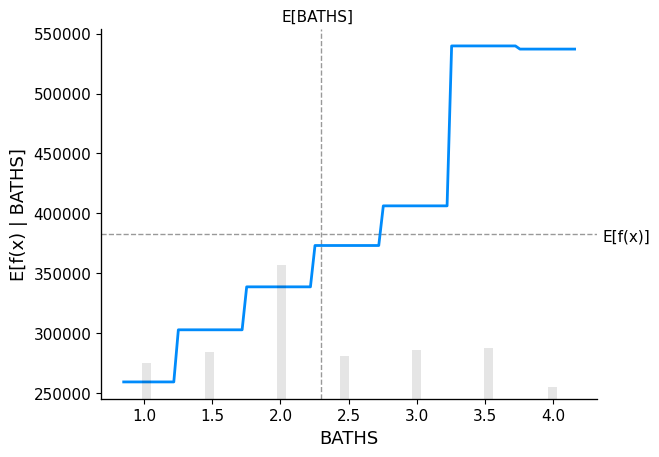

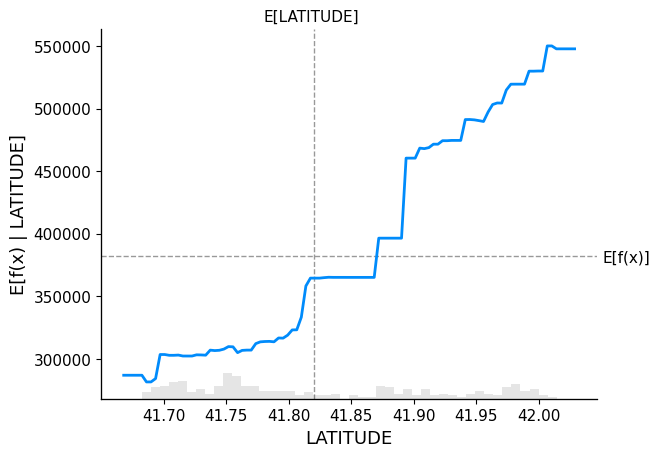

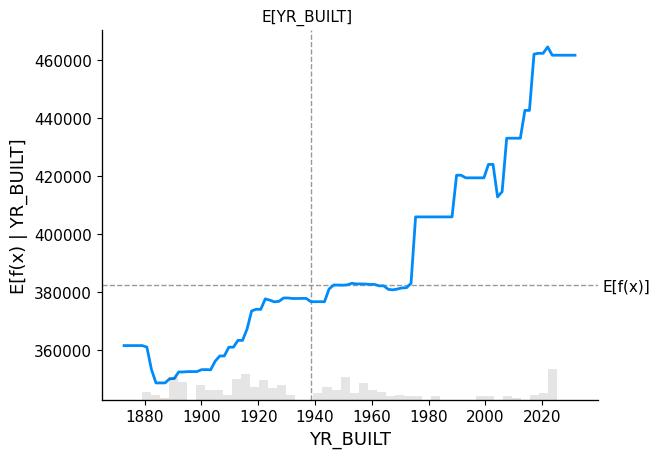

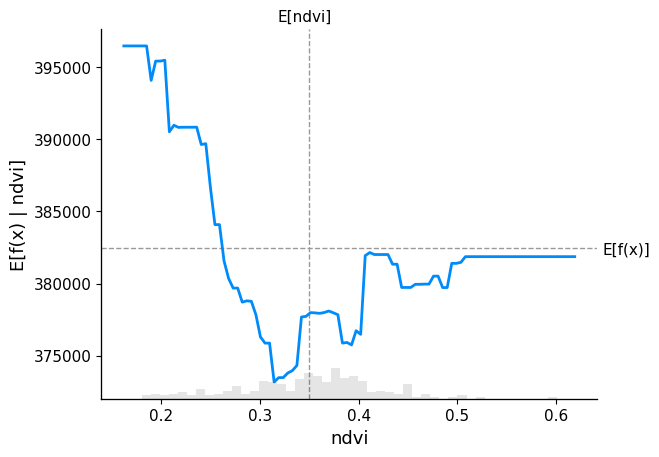

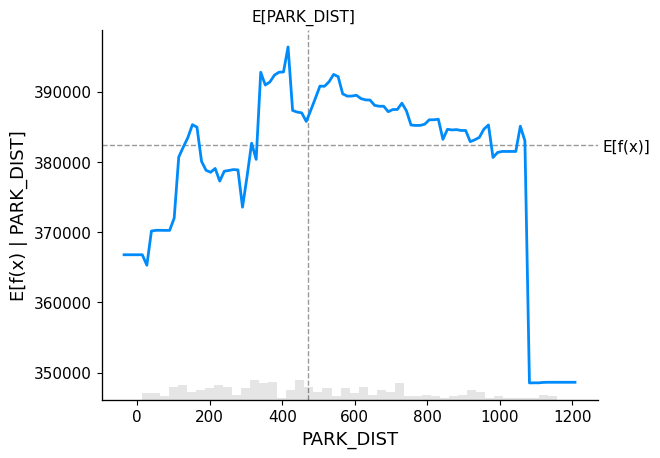

In [ ]:
features = ['FnB_COUNTS', 'BATHS', 'LATITUDE', 'YR_BUILT','ndvi', 'PARK_DIST']

for feature in features:

    shap.plots.partial_dependence(feature, cb_mdl.predict, X_test,\
                                ice=False, model_expected_value=True,\
                                feature_expected_value=True)

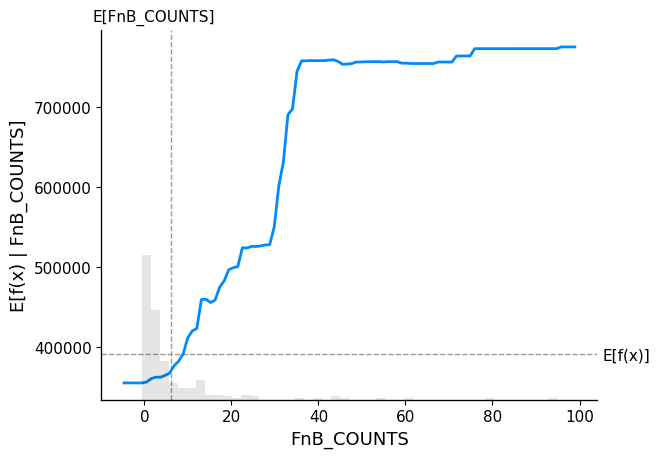

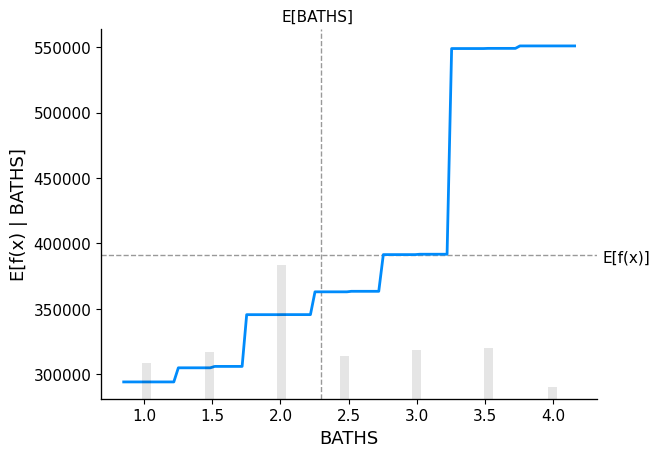

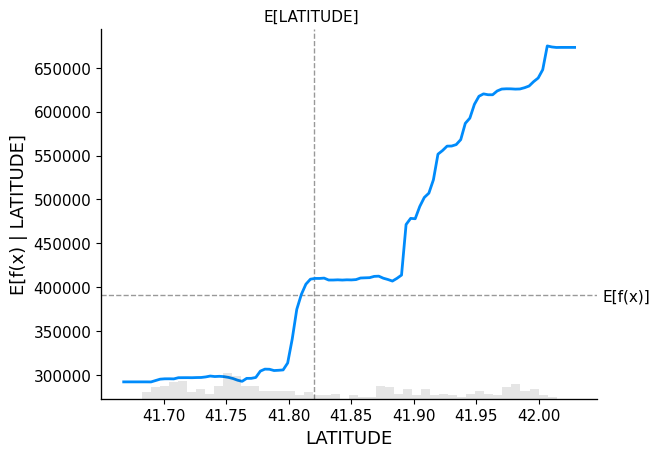

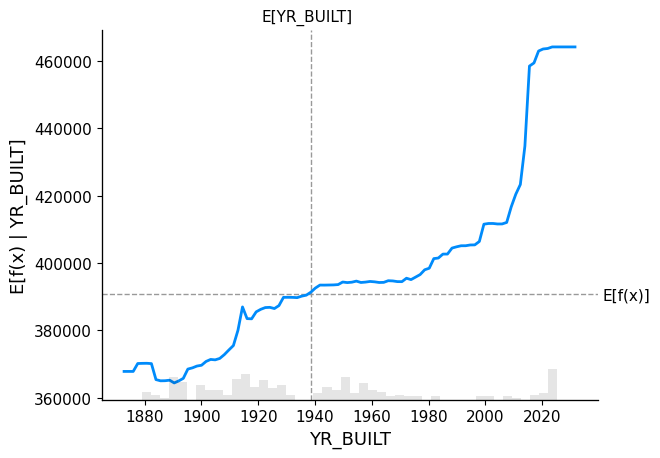

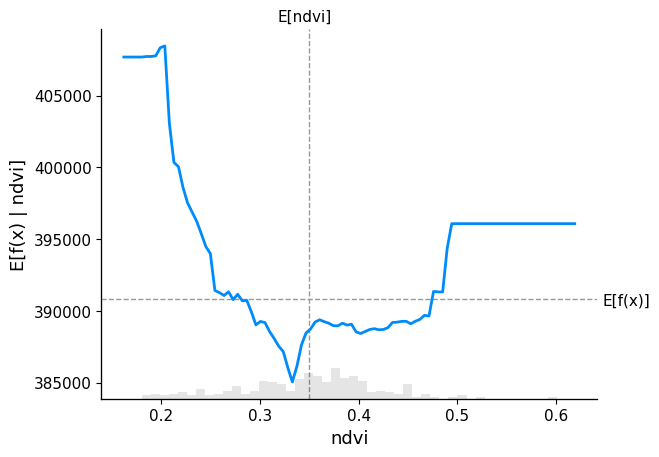

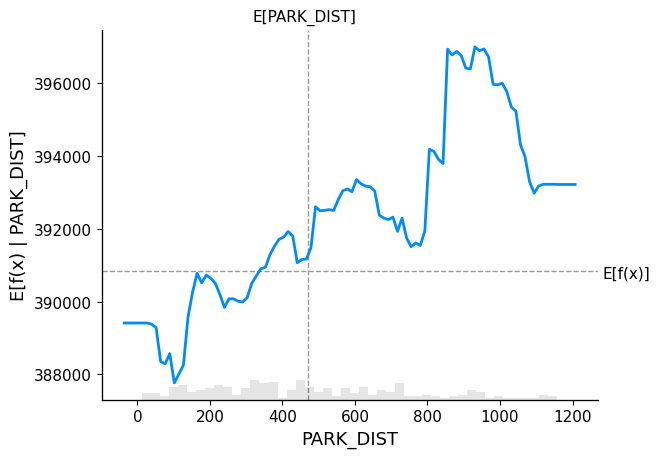

In [ ]:
for feature in features:

    shap.plots.partial_dependence(feature, rf_mdl.predict, X_test,\
                                ice=False, model_expected_value=True,\
                                feature_expected_value=True)

## PDP - PDPBOX

In [ ]:
features = ['LATITUDE', 'YR_BUILT','ndvi','PARK_DIST']

for feat in features:

    pdp_single_feature = pdp.PDPIsolate(
        model=cb_mdl, df=X_test, model_features=X_test.columns, feature=feat,\
        feature_name=feat, n_classes=0, n_jobs=-1
    )
    fig, axes = pdp_single_feature.plot(plot_pts_dist=True)
    fig.show()

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
fig, axes = pdp_single_feature.plot(plot_pts_dist=True, plot_lines=True,\
                                    frac_to_plot=0.05)
fig.show()

In [ ]:
fig, axes = pdp_single_feature.plot(to_bins=True, plot_lines=True,\
                                    frac_to_plot=0.01, show_percentile=True)
fig.show()

## ALE

In [ ]:
# Remove outliers

X_test_no_outliers = X_test[(X_test.FnB_COUNTS.quantile(.01) <= X_test.FnB_COUNTS) &\
                           (X_test.FnB_COUNTS <= X_test.FnB_COUNTS.quantile(.99)) &\
                           (X_test.YR_BUILT.quantile(.01) <= X_test.YR_BUILT) &\
                           (X_test.YR_BUILT <= X_test.YR_BUILT.quantile(.99)) &\
                           (X_test.LATITUDE.quantile(.01) <= X_test.LATITUDE) &\
                           (X_test.LATITUDE <= X_test.LATITUDE.quantile(.99))]

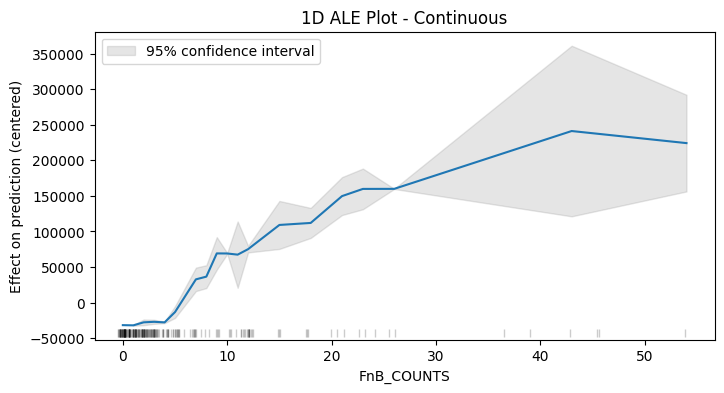

In [ ]:
ale_effect = ale(X=X_test_no_outliers, model=cb_mdl, feature=['FnB_COUNTS'],\
                 feature_type='continuous', grid_size=80) 
plt.show()

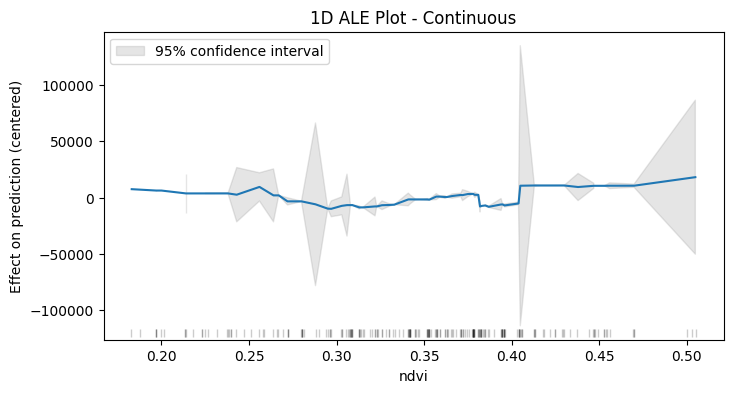

In [ ]:
ale_effect = ale(X=X_test_no_outliers, model=cb_mdl, feature=['ndvi'],\
                 feature_type='continuous', grid_size=80) 
plt.show()

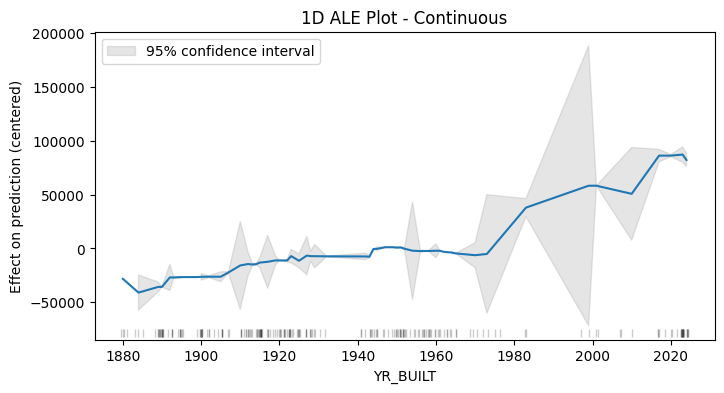

In [ ]:
ale_effect = ale(X=X_test_no_outliers, model=cb_mdl, feature=['YR_BUILT'],\
                 feature_type='continuous', grid_size=80) 
plt.show()

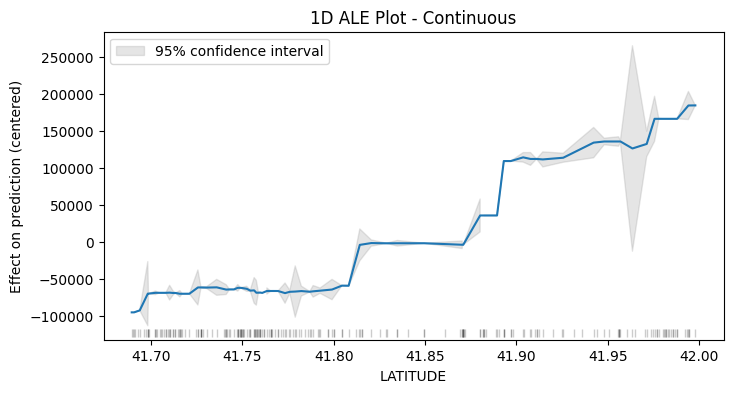

In [ ]:
ale_effect = ale(X=X_test_no_outliers, model=cb_mdl, feature=['LATITUDE'],\
                 feature_type='continuous', grid_size=80) 
plt.show()

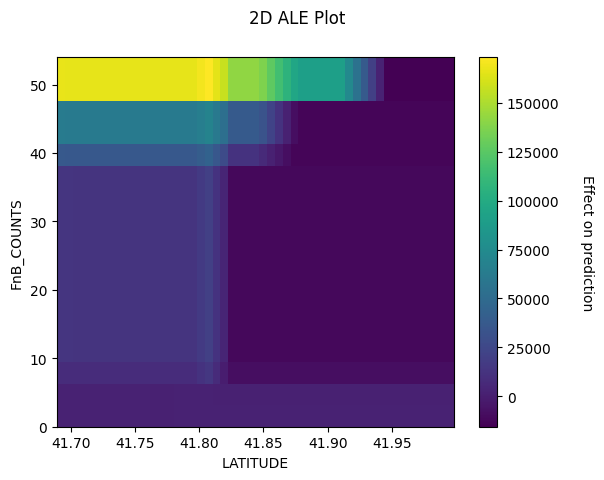

In [ ]:
features_l = ["FnB_COUNTS", "LATITUDE"]

mpl.rcParams["image.aspect"] = "auto"
ale_effect = ale(X=X_test_no_outliers, model=cb_mdl, feature=features_l,\
                 feature_type='continuous', grid_size=50, include_CI=False) 
plt.show()

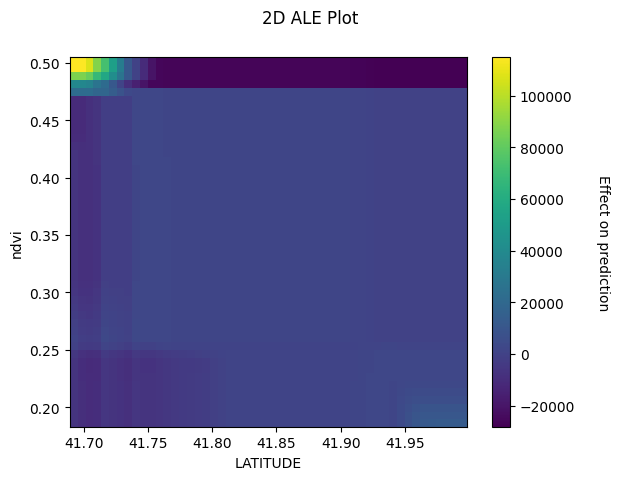

In [ ]:
features_l = ["ndvi", "LATITUDE"]

mpl.rcParams["image.aspect"] = "auto"
ale_effect = ale(X=X_test_no_outliers, model=cb_mdl, feature=features_l,\
                 feature_type='continuous', grid_size=50, include_CI=False) 
plt.show()

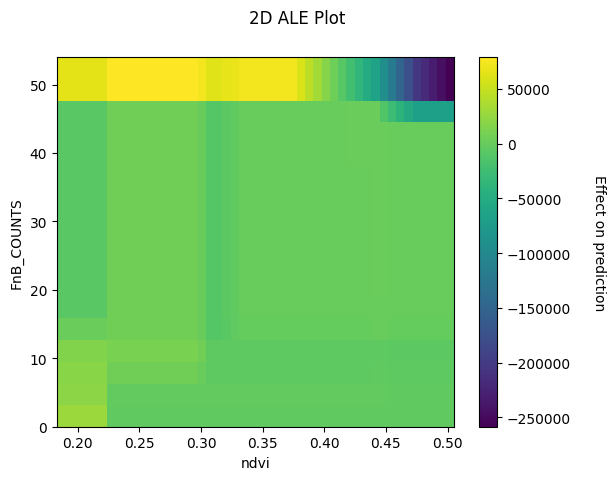

In [ ]:
features_l = ["FnB_COUNTS", "ndvi"]

mpl.rcParams["image.aspect"] = "auto"
ale_effect = ale(X=X_test_no_outliers, model=cb_mdl, feature=features_l,\
                 feature_type='continuous', grid_size=50, include_CI=False) 
plt.show()

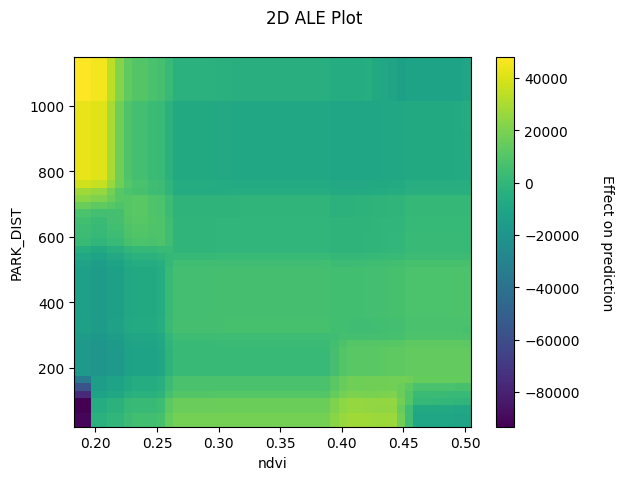

In [ ]:
features_l = ["PARK_DIST", "ndvi"]

mpl.rcParams["image.aspect"] = "auto"
ale_effect = ale(X=X_test_no_outliers, model=cb_mdl, feature=features_l,\
                 feature_type='continuous', grid_size=50, include_CI=False) 
plt.show()

In [ ]:
print(X_test_no_outliers.columns)

Index(['index', 'ZIP', 'BEDS', 'BATHS', 'LOT', 'YR_BUILT', 'DAYS ON MA',
       'HOA/MONTH', 'LATITUDE', 'LONGITUDE', 'PARK_DIST', 'HOSPITAL_D',
       'RAIL_DIST', 'BUS_COUNTS', 'FnB_COUNTS', 'ndvi', 'x'],
      dtype='object')


In [ ]:
print(ale_effect)

ndvi              0.183         0.197         0.214         0.225  \
PARK_DIST                                                           
20        -90948.721722 -90948.721722  -3338.181583  -3361.219439   
41        -90948.721722 -90948.721722  -3338.181583  -3361.219439   
79        -93317.260173 -93317.260173  -5706.720035  -5729.757890   
94        -93317.260173 -93317.260173  -5706.720035  -5729.757890   
115       -76563.280521 -76563.280521 -11416.981443 -11440.019299   
128       -57014.848266 -57014.848266 -14332.790250 -14355.828105   
139       -34550.607205 -34550.607205 -14332.790250 -14355.828105   
166       -17305.843222 -17305.843222 -19552.267328 -19575.305184   
177       -17305.843222 -17305.843222 -19552.267328 -19575.305184   
204       -17305.843222 -17305.843222 -19552.267328 -19575.305184   
213       -17336.107584 -17336.107584 -19582.531690 -19595.330498   
228       -16900.491721 -16900.491721 -19146.915827 -19149.475589   
241       -15630.059590 -15630.059

## SHAP

In [ ]:
X_samp = X.sample(frac=0.1)
y_samp = y.loc[X_samp.index]
clustering = shap.utils.hclust(X_samp, y_samp)

In [ ]:
np.set_printoptions(suppress=True)
print(clustering)

[[ 8.          9.          0.3549448   2.        ]
 [ 2.          3.          0.59435987  2.        ]
 [ 4.         16.          0.63952184  3.        ]
 [14.         17.          0.74639755  3.        ]
 [11.         15.          0.76500136  2.        ]
 [ 7.         10.          0.80614245  2.        ]
 [12.         13.          0.8240515   2.        ]
 [ 0.          6.          0.83143461  2.        ]
 [ 1.         20.          0.83432418  3.        ]
 [ 5.         24.          0.83885849  4.        ]
 [23.         25.          0.83891487  6.        ]
 [18.         26.          0.84177744  9.        ]
 [19.         27.          0.86001366 12.        ]
 [21.         28.          0.86823738 14.        ]
 [22.         29.          0.8792755  16.        ]]


In [ ]:
# Create a SHAP explainer
explainer = shap.TreeExplainer(rf_mdl)

# Compute SHAP values for test data
shap_values = explainer.shap_values(X_test)

In [ ]:
X_test

,index,ZIP,BEDS,BATHS,LOT,YR_BUILT,DAYS ON MA,HOA/MONTH,LATITUDE,LONGITUDE,PARK_DIST,HOSPITAL_D,RAIL_DIST,BUS_COUNTS,FnB_COUNTS,ndvi,x
2466,3883,60628,3.0,1.5,0,1975,18,0.0,41.720959,-87.641676,604,4666,1933,31,0,0.394,6.0
1687,3425,60619,3.0,2.5,0,1920,95,0.0,41.750156,-87.587225,759,1111,4225,51,4,0.378,7.0
1213,279,60656,5.0,4.0,5000,1961,33,0.0,41.971378,-87.805725,993,2496,1676,29,0,0.371,8.0
2205,3521,60621,5.0,2.0,3125,1890,243,0.0,41.787523,-87.642282,506,1689,1283,33,0,0.429,5.0
2303,3268,60619,5.0,1.5,10890,1915,209,0.0,41.756413,-87.613566,1140,3172,1572,47,5,0.345,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,4419,60617,3.0,1.0,3149,1944,23,0.0,41.747444,-87.576167,261,834,5474,37,1,0.357,2.0
2059,401,60609,5.0,2.5,0,1919,197,0.0,41.808163,-87.644644,640,3544,1551,28,3,0.247,6.0
30,1338,60609,3.0,1.5,3750,1883,25,0.0,41.796672,-87.632800,213,2308,261,42,2,0.232,1.0
2397,3478,60620,6.0,2.0,0,1927,101,0.0,41.756333,-87.672387,673,2939,3507,31,0,0.342,6.0


In [ ]:
X_test = X_test[X_train.columns]  # Reorder columns to match training data

PermutationExplainer explainer: 228it [00:32,  4.85it/s]                         


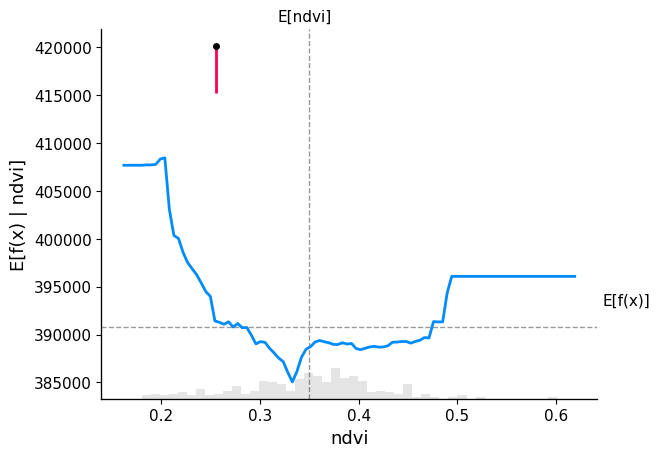

In [ ]:
# Create SHAP explainer for Random Forest
explainer = shap.Explainer(rf_mdl.predict, X_test)  

# Compute SHAP values
shap_values = explainer(X_test)

# Select a sample instance for partial dependence plot
sample_ind = 15  

# Generate the Partial Dependence Plot (PDP) for a specific feature (e.g., 'odometer')
shap.partial_dependence_plot(
    "ndvi",  # Replace with your feature name
    rf_mdl.predict,  
    X_test,  
    model_expected_value=True,  
    feature_expected_value=True,  
    ice=False,  # Setting ICE (Individual Conditional Expectation) to False
    shap_values=shap_values[sample_ind : sample_ind + 1, :],
)


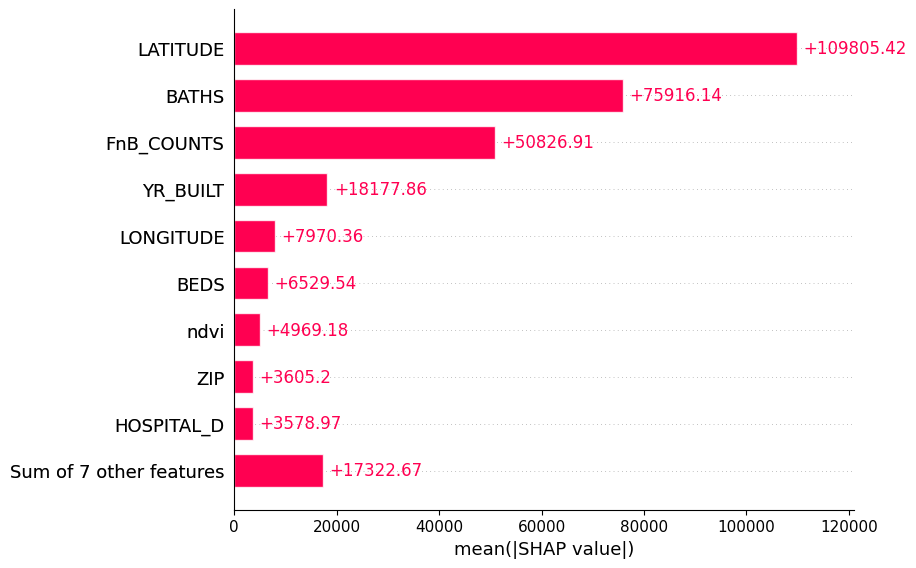

In [ ]:
shap.plots.bar(shap_values)

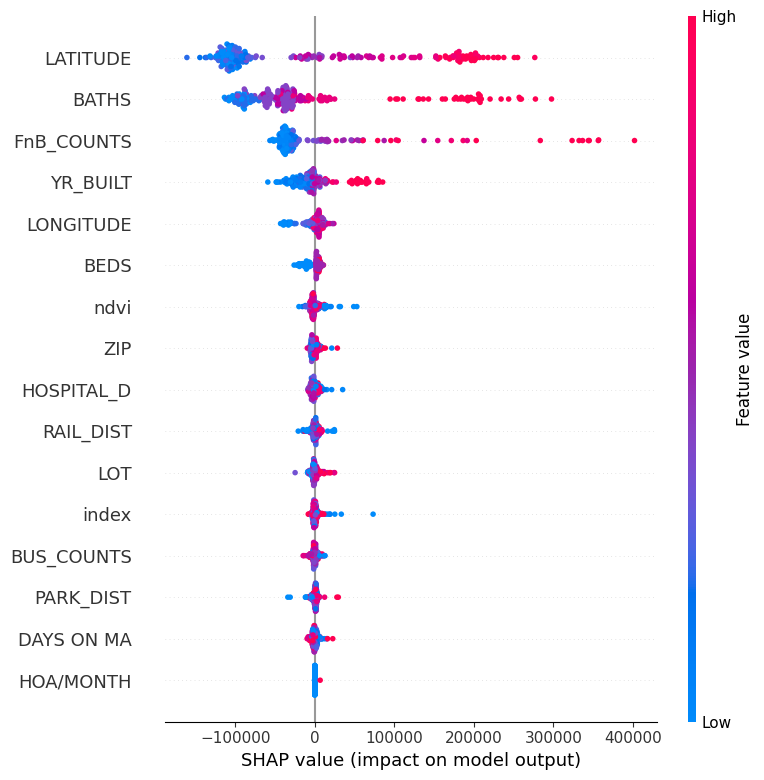

In [ ]:
shap.summary_plot(shap_values, X_test)

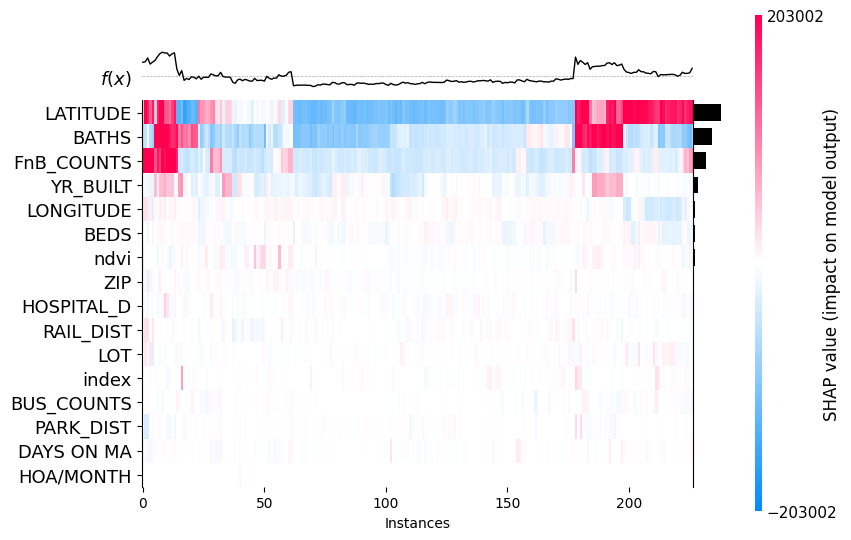

<Axes: xlabel='Instances'>

In [ ]:
shap.plots.heatmap(shap_values, max_display=20)

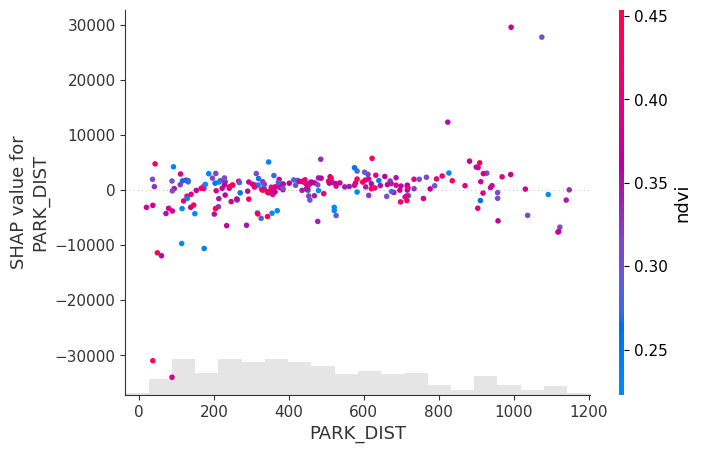

In [ ]:
shap.plots.scatter(shap_values[:, "PARK_DIST"], color=shap_values[:, "ndvi"])

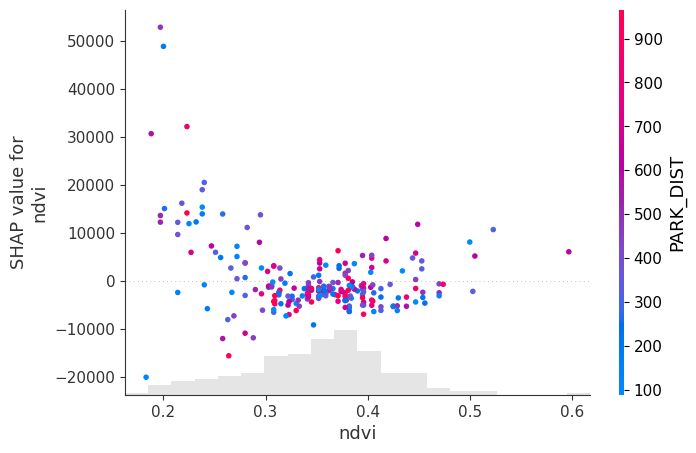

In [ ]:
shap.plots.scatter(shap_values[:, "ndvi"], color=shap_values[:, "PARK_DIST"])

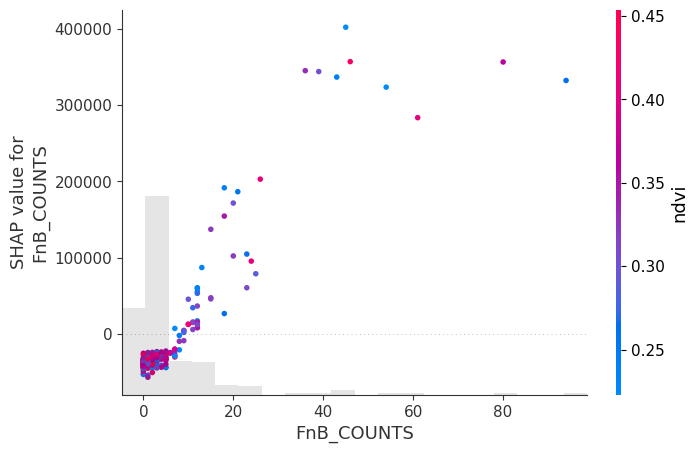

In [ ]:
shap.plots.scatter(shap_values[:, "FnB_COUNTS"], color=shap_values[:, "ndvi"])

## Analysis and Summary

1. Permutation Feature Importance

I fitted a CatBoost Model and a Random Forest Model to the dataset. The importance of both models in terms of permutation features shows similar results. The top features are FnB_COUNTS (Nearby Food and Beverage Counts), BATHS (Bathroom Counts), Latitude, and YR_BUILT (Built year). Housing prices are related to commercial ambiance, size, location, and age. 

2. PDP

After further analyzing these features using PDP, I found that for Latitude, there is a significant jump at 41.8, corresponding to the location of the Loop, and the value continues to increase moving towards the northern neighborhoods, verifying significant north-south segregation in the housing price of Chicago. 

The PDP of YR_BUILT shows a significant jump around 2003, meaning the constructions after 2003 have a larger impact on the housing price prediction. This reflects the current market preference for housing age. This might also be related to the housing boom before the 2008 global crisis, which was caused by the overheated housing market.

3. ALE

Compared to PDP, ALE shows a more robust result in feature correlation and capturing local variations in prediction. After comparing the ALE results to the PDP results, I noticed that the overall trend of the two methodologies is quite similar. For YR_BUILT (built year), the significant jump appears around 2003 in both ALE and PDP. For Latitude, the significant jump also appears around latitude 41.8. However, there is a minor difference between latitude 41.84 and latitude 41.86 (Near South Side), where ALE does not show any change in value. This indicates the stability of the local housing market in the Near South Side. It also signals a significant price shift entering the Loop housing market. I also ran a 2D ALE analysis between features FnB_Counts, YR_BUILT, and Latitude. In the FnB_Counts vs. Latitude ALE Plot, in the southern neighborhoods, a medium level of commercial ambiance (FnB_Counts = 50 to 80) shows a larger positive impact on the housing price prediction, while in the city center, a high level of commercial ambiance (FnB_Counts >80) shows a negative impact on the housing price prediction, indicating the preference of commercial environment in different Chicago neighborhood.

4. SHAP

SHAP values combine both global and local explanations. Similarly, the top-ranked features based on the SHAP values are still BATHS, FnB_Counts, Latitude, and YR_BUILT. The SHAP summary plot provides some additional details about the features. Both features of the property (Bathroom Counts and YR_BUILT) and features of the surrounding environment (FnB_Counts and Latitude) play an important role in predicting housing prices. Houses with more bathrooms and more nearby restaurants contribute more to a higher housing price prediction. A higher latitude also shows a positive influence on the model prediction, indicating the locational preference in Chicago. According to the SHAP values of the feature YR_BUILT, newer buildings' positive contribution to the model prediction is stronger than older buildings' negative impact.